# Persistence diagrams from ensembles
This script makes some of the plots from the paper. It assumes that you have run generate_ensembles.py first to create a Congressional ensembles for Pennsylvania, stored as graphs18.p and parts18.p. 

We only show a PA Congressional ensemble here, but it's easy to adapt this to other scales, or even other states. 

In [1]:
from gerrychain import Graph, Election, updaters, Partition, constraints, MarkovChain
from gerrychain.updaters import cut_edges
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept
from gerrychain.random import random
from gerrychain.constraints import single_flip_contiguous
import numpy as np
import operator
from functools import partial
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import pickle
import sys, os
import networkx as nx
from collections import defaultdict
import tdaredistricting as tdar

## Load in the shapefile data
The PA shapefile used here is available along with many others at github.com/mggg-states. The election_names and election_columns have to be changed when changing from PA to a different state.

In [2]:
#updaters
election_names = ["PRES16", "SEN16", "ATG12", "GOV14", "GOV10", "PRES12", "SEN10", "ATG16", "SEN12"]
election_columns = [
    ["T16PRESD", "T16PRESR"],
    ["T16SEND", "T16SENR"],
    ["ATG12D", "ATG12R"],
    ["F2014GOVD", "F2014GOVR"],
    ["GOV10D", "GOV10R"],
    ["PRES12D", "PRES12R"],
    ["SEN10D", "SEN10R"],
    ["T16ATGD", "T16ATGR"],
    ["USS12D", "USS12R"]
] #DEM, REP
pop_tol = 0.02
pop_col = "TOTPOP"
myupdaters = {
    "population": updaters.Tally(pop_col, alias="population"),
}
elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(len(election_names))
]
election_updaters = {election.name: election for election in elections}
myupdaters.update(election_updaters)
allparts = {}
allgraphs = {}

In [3]:
gdf = gpd.read_file("PA_VTD_PLANS/PA_VTD_PLANS.shp")
graph = Graph.from_json("PA_VTD.json")

In [4]:
gdf = gdf.to_crs({"init":"epsg:2271"})

## Compute persistence diagrams for PRES16
We filter up by Republican share under Presidential 2016 vote share and compute 0th homology

In [5]:
#compute PDs for PRES16
storePDs = {e:{} for e in election_names}
folder = "."
for k in [18]:
    graphs = pickle.load(open(folder+"/graphs"+str(k)+".p", "rb"))
    for e in ["PRES16"]:
        print(e, k, "districts")
        PDs = []
        for g in graphs[e]:
            PD = tdar.persistence_diagram_from_graph(g[0], g[1])
            PD[-1] = (PD[-1][0], 1)
            PD = sorted(PD, key=lambda x: x[1]-x[0])
            PDs.append(PD)
        storePDs[e][k] = PDs.copy()

PRES16 18 districts


## Compute Frechet mean for PRES16
We compute a locally optimal average diagram for the PRES16 persistence diagrams.

In [6]:
#get Frechet means
meanPDs = {e:{} for e in election_names}
for k in [18]:
    X = []
    Y = []
    graphs = pickle.load(open(folder+"/graphs"+str(k)+".p", "rb"))
    for e in ["PRES16"]:
        print(k, e)
        PDs = storePDs[e][k]
        for pd in PDs:
            pd[-1] = (pd[-1][0], 10000)
        meanPD = tdar.Frechet_mean(PDs) #can be changed to Frechet_mean_reseed for robust results
        meanPD = sorted(meanPD, key=lambda x: x[1]-x[0], reverse=True)
        meanPD[0] = (meanPD[0][0], 1)
        meanPDs[e][k] = meanPD.copy()
        for pd in PDs:
            pd[-1] = (pd[-1][0], 1)

18 PRES16


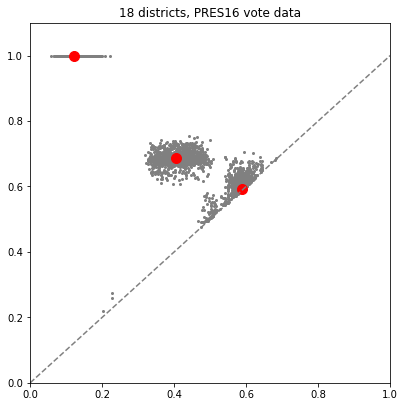

In [7]:
#all together (with Frechet means)
for k in [18]:
    for e in ["PRES16"]:
        X, Y = [], []
        PDs = storePDs[e][k]
        for PD in PDs:
            X.extend([x[0] for x in PD])
            Y.extend([x[1] for x in PD])
            
        fig = plt.figure(figsize=(5,5))
        ax = plt.gca()
        ax.scatter(X, Y, c="gray", s=4)
        ax.scatter([m[0] for m in meanPDs[e][k]], [m[1] for m in meanPDs[e][k]], s=100, c='red')
        plt.xlim(0,1)
        plt.ylim(0,1.1)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.plot([0,1],[0,1],linestyle='dashed',c='gray')
        plt.title("{} districts, {} vote data".format(k, e))
        plt.show()

## Frechet point plots
We mark points in each persistence diagram by points in the Frechet mean and group them by this marking to produce _Frechet point plots_.

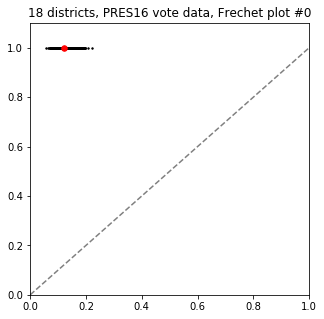

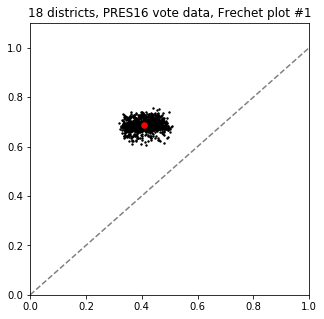

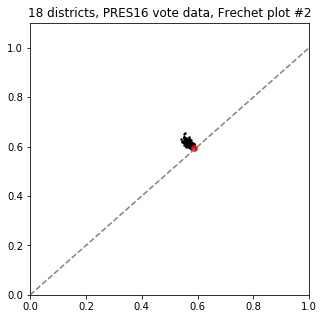

In [8]:
#Frechet point plots
for k in [18]:
    for e in ["PRES16"]:
        PDs = []
        for PD in storePDs[e][k]:
            pd = tdar.match_Hungarian(PD, meanPDs[e][k])
            PDs.append(pd)
        for r in range(len(meanPDs[e][k])):
            nontrivialpoints = [PD[r] for PD in PDs if PD[r] not in [None, 'd']]
            X = [x[0] for x in nontrivialpoints]
            Y = [x[1] for x in nontrivialpoints]
            fig = plt.figure(figsize=(5,5))
            ax = plt.gca()
            ax.scatter(X, Y, c="black", s=2)
            ax.scatter([meanPDs[e][k][r][0]], [meanPDs[e][k][r][1]], s=30, c='red')
            plt.xlim(0,1)
            plt.ylim(0,1.1)
            plt.plot([0,1],[0,1],linestyle='dashed',c='gray')
            plt.title("{} districts, {} vote data, Frechet plot #{}".format(k, e, r))
            plt.show()

## Different elections' Frechet means
We can compute the Frechet means for multiple elections and compare them

PRES16 SEN16 ATG12 GOV14 GOV10 PRES12 SEN10 ATG16 SEN12 

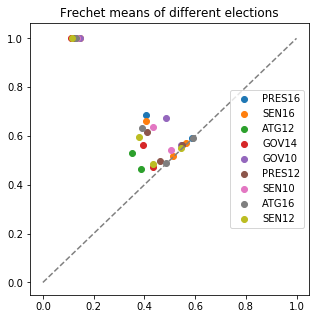

In [9]:
#plot Frechet means -- may take a while to run
for k in [18]:
    X = []
    Y = []
    labels = []
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.plot([0,1], [0,1], c='gray',  linestyle='dashed')
    ax.set_title("Frechet means of different elections")
    graphs = pickle.load(open(folder+"/graphs"+str(k)+".p", "rb"))
    for e in election_names:
        print(e, end=" ")
        PDs = []
        for g in graphs[e]:
            PD = tdar.persistence_diagram_from_graph(g[0], g[1])
            PD[-1] = (PD[-1][0], 10000)
            PDs.append(PD)
        meanPD = tdar.Frechet_mean(PDs)
        meanPD[-1] = (meanPD[-1][0], 1)
        meanPD = sorted(meanPD, key=lambda x:x[1]-x[0],reverse=True)
        meanPDs[e][k] = meanPD.copy()
        ax.scatter(
            [m[0] for m in meanPD],
            [m[1] for m in meanPD],            
            label=e
        )
        X.extend([m[0] for m in meanPD])
        Y.extend([m[1] for m in meanPD])
        labels.extend([e for m in meanPD])
        ax.legend(loc='right')
    plt.show()


## Localizing Frechet point plots
Each point in a Frechet point plot is represented by a _birth district_. Let's take the Frechet point plots one by one and see where these birth districts lie.

In [10]:
for k in [18]:
    allparts[k] = pickle.load(open(folder+"/parts"+str(k)+".p", "rb"))
    allgraphs[k] = pickle.load(open(folder+"/graphs" +str(k)+ ".p", "rb"))

In [11]:
#generate Gerrychain partition objects with districts labelled ascending by D vote share
list_of_ranked_plans = defaultdict(lambda: defaultdict(list))
for k in [18]:
    asses = allparts[k] 
    unrankedparts = [
        Partition(graph, x, myupdaters) for x in asses
    ]
    for e in ["PRES16"]:
        list_of_ranked_plans[e][k] = [
            tdar.relabel_by_dem_vote_share(x, x[e]) for x in unrankedparts
        ]

Rendering peak 0


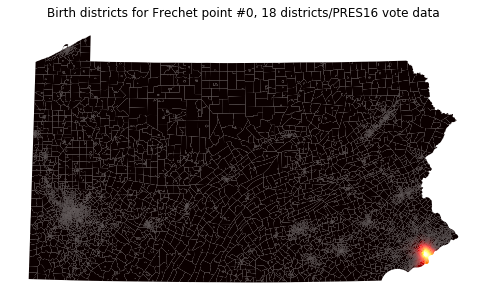

Rendering peak 1


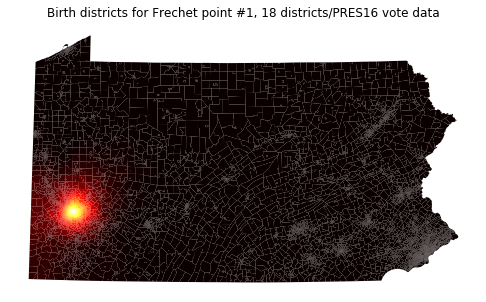

Rendering peak 2


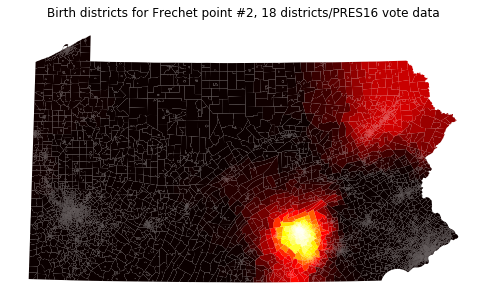

In [12]:
for k in [18]:
    asses = allparts[k] 
    for e in ["PRES16"]:
        rankedparts = list_of_ranked_plans[e][k]
        #get persistence diagrams matched to means
        PDs = []
        for PD in storePDs[e][k]:
            pd = tdar.match_Hungarian(PD, meanPDs[e][k])
            PDs.append(pd)
        #plot on map
        for r in range(len(meanPDs[e][k])):
            print("Rendering peak %d"%r)
            incomp = np.zeros(len(graph.nodes)) #track how often each unit is in a birth district
            for i, (part, PD) in enumerate(zip(rankedparts, PDs)):
                if PD[r] not in [None, 'd']:
                    birth, death = PD[r][0], PD[r][1] 
                    birth_district = np.argmin(
                        [np.abs((1-birth)-(x)) for x in sorted(part[e].percents('Democratic'))]
                    )
                    this_incomp = [int(x in part.parts[birth_district]) for x in graph.nodes]
                    incomp += np.array(this_incomp)
            gdf["incomp"] = incomp
            smallfig, smallax = plt.subplots(1,1,figsize=(10,5))
            gdf.plot(column="incomp", cmap="hot", ax=smallax)
            smallax.axis('off')
            smallax.set_title("Birth districts for Frechet point #{}, {} districts/{} vote data".format(r,k,e))
            plt.show()


# Finding zones of Democratic support
Each connected component of Democratic-won districts in a plan corresponds to a persistence point with birth < 0.5 and death > 0.5, and thus also to a Frechet mean point (or possibly the diagonal). We plot the location of these connected components for each Frechet mean point, as well as how many districts were in this connected component on average.

Rendering zone 0


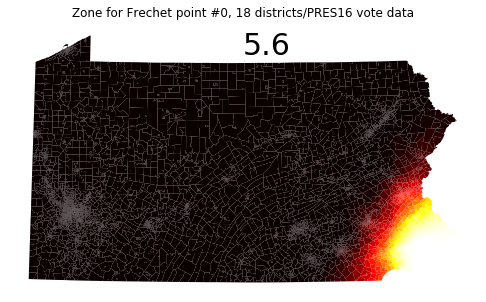

Rendering zone 1


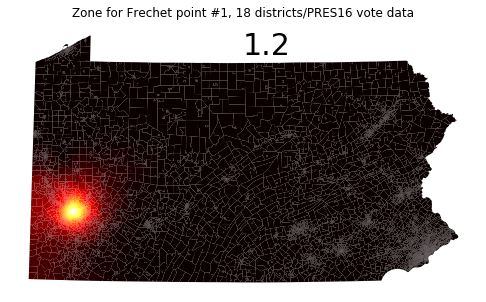

Rendering zone 2


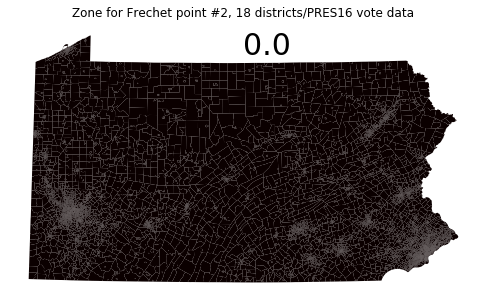

In [13]:
annotate_X, annotate_Y = 2000000, 700000 #where to put numbers
for k in [18]:
    for e in ["PRES16"]:
        rankedparts = list_of_ranked_plans[e][k]
        #get persistence diagrams matched to means
        PDs = []
        for PD in storePDs[e][k]:
            pd = tdar.match_Hungarian(PD, meanPDs[e][k])
            PDs.append(pd)
        #get connected components of Democratic support
        node_clusters = defaultdict(list)
        for g, PD in zip(graphs[e], PDs):
            for i in range(len(meanPDs[e][k])):
                if PD[i] != 'd' and 1-PD[i][0] > 0.5 and PD[i][1] > 0.5:
                    node_for_i = np.argmin([np.abs((1-x)-PD[i][0]) for x in g[1]])
                    subgraph = g[0].subgraph([n for n in g[0].nodes if g[1][n] > 0.5])
                    node_clusters[i].append(list(nx.node_connected_component(subgraph,node_for_i)))
                else:
                    node_clusters[i].append([])
        #plot on map
        for i in range(len(meanPDs[e][k])):
            print("Rendering zone %d"%i)
            incomp = np.zeros(len(gdf))
            for l, p in list(zip(node_clusters[i], rankedparts)):
                thisincomp = [int(p.assignment[n] in l) for n in graph.nodes]
                incomp = incomp + np.array(thisincomp)
            gdf["incomp"] = incomp
            smallfig, smallax = plt.subplots(1,1,figsize=(10,5))
            gdf.plot(column="incomp", cmap="hot", ax=smallax)
            meanDs = np.mean([len(x) for x in node_clusters[i]])
            smallax.annotate(
                "{:.1f}".format(meanDs),
                (annotate_X,annotate_Y),
                fontsize=30,
                c='black'
            )
            smallax.axis('off')
            smallax.set_title("Zone for Frechet point #{}, {} districts/{} vote data".format(i,k,e))
            plt.show()